# Exercise sheet 3

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import rankdata
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

###### Reference: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
### Function Name: pearson_coefficient: 
##### Parameter: Data for correlation
   The Pearson correlation coefficient (PCC) is a measure of the linear correlation between two variables X and Y. PCC or 'r' has a value between +1 and −1

\begin{align}
r = \frac{\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {{\sum _{i=1}^{n}}(x_{i}-{\bar {x}})^2}\sqrt {{\sum _{i=1}^{n}}(y_{i}-{\bar {y}})^2}} \\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php
    
    Assumptions:
        1.The variables must be either interval or ratio measurements.
        2.The variables must be approximately normally distributed.
        3.There is a linear relationship between the two variables
        4.Outliers are either kept to a minimum or are removed entirely.
        5.There is homoscedasticity of the data.


In [49]:
def pearson_coefficient(x,y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    return (np.sum(x*y)/np.sqrt(np.sum(x*x)*np.sum(y*y)))
    

###### Reference: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
### Function Name: spearman_rank_coefficient: 
##### Parameter: Data for correlation
   The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, (ρ, also signified by rs) measures the strength and direction of association between two ranked variables.



\begin{align}
r_{s} = \rho_{rg_{X},rg_{Y}} = \frac{cov(rg_{x},rg_{y})}{\sigma_{rg_{X},rg_{Y}}}\\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
    
    Assumption:   You need two variables that are either ordinal, interval or ratio

In [50]:
def spearman_rank_coefficient(x,y):
    rank_x = rankdata(x)
    rank_y = rankdata(y)
    
    return pearson_coefficient(rank_x,rank_y)

### Function Name: read_data
##### Parameter: Filename,column names
This function reads the data and returns the data with its headers

In [51]:
def read_data(filename,columns,delimit):
    if columns == None:
        data = pd.read_csv(filename, sep='\s+', delimiter = delimit)
        return data
    data = pd.read_csv(filename, sep='\s+',header = None)
    data.columns = columns
    return data

### Function Name: check_na_null
##### Parameter: dataframe, column names

This function checks the presence of null or NA values within the dataset

In [52]:
def check_na_null(data):
    data.isnull().values.any()
    data.dropna(inplace = True)
    data = pd.get_dummies(data=data)
    return data

In [53]:
def text_to_number(data,column):
    for i in column:
        data[i] = pd.Categorical(data[i])
        data[i] = data[i].cat.codes
    return data

###### Reference: http://mathworld.wolfram.com/FrobeniusNorm.html
### Function name: normalise_data
###### Parameters: data to be normalised

numpy.linalg.norm function returns the normalisation of a matrix. By default, it returns Forbenius Norm of a matrix

\begin{align}
{A}_{norm} = \sqrt{\sum_{i=1}^m\sum_{j=1}^n |A_{i,j}|^2} \\
\end{align}

In [54]:
def normalise_data(data):
    norm_data = data.copy()
    for columns in norm_data:
        norm_data[columns] = norm_data[columns]/np.linalg.norm(norm_data[columns])
    return norm_data

def denormalise_data(data,norm_data):
    denorm_data = norm_data.copy()
    denorm = np.linalg.norm(data[str(data.columns[-1])])
    for i in range (0,len(norm_data)):
        for j in range (0,len(norm_data[i])):
            denorm_data[i][j] = norm_data[i][j] * denorm
    return denorm_data

In [55]:
def rmse(y_data,y_pred):
    return np.sqrt(np.sum(pow((y_data - y_pred),2)))/len(y_pred)

### Function Name: create_Test_Train_data
### Parameter: Data of input variables and target
This function splits the input variables and target data to Train and Test data with 80% and 20% of the data respectively

In [56]:
def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.8*len(Y_data))]
    Y_test = Y_data[math.ceil(0.8*len(Y_data)):]
    X_train = X_data[:math.ceil(0.8*len(X_data))]
    X_test = X_data[math.ceil(0.8*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

#### Bold driver step length for controlling the learning rate

\begin{align}
\mu = \mu.\mu^{+}\\
\mu = \mu.\mu^{-}
\end{align}

In [57]:
def bold_steplength(alpha,f_new,f_old):
    
    alpha_plus = 1.1
    alpha_minus = 0.5
    if f_new < f_old:
        alpha = alpha * alpha_plus
    else:
        alpha = alpha * alpha_minus
    return alpha

#### Adagrad steplength controller

\begin{align}
\beta_{new} = \beta_{old} - \frac{\mu}{\sqrt{h}}G\\
G = X^{T}(y-p)\\
h = {h + G*G}
\end{align}

In [58]:
def adagrad_steplength(alpha,beta,xtr,ytr,history):
    error =  ytr - 1/(1 + np.exp(-np.dot(beta,xtr.T)))
    grad = - (xtr.T * error)
    grad_sq = np.dot(grad, grad.T)
    print(grad_sq)
    for i in range(0,len(history)):
        history[i] += float(grad_sq[i][i]) + 1e-10
        beta[i] = beta[i] - float((alpha/np.sqrt(history[i])) 
                                  * grad[i])
    
    return beta,history

#### Optimizing the loglikelihood function

\begin{align}
log L_{D}(\hat{\beta}) = \sum_{n=1}^Ny_{n}(x_{n}.\hat{\beta}) - log(1+e^{(x_{n}.\hat{\beta})})
\end{align}

In [59]:
def loglikelihood(Y,betaX):
    return  np.sum(np.dot(Y,betaX) - np.log(1 + np.exp(betaX)))

###### Reference: http://wiki.fast.ai/index.php/Log_Loss#Binary_Classification
#### To calculate logarthmic loss on the test set
In binary classification (M=2), the formula equals:

\begin{align}
-y(log(p))+(1-y)(log(1-p))
\end{align}


In [60]:
def logloss(Ytest,Xtest,beta,type):
    if type == 'Test':
        X = np.insert(Xtest, 0, 1, axis = 1)
        betaX = np.dot(beta,X.T)
        Y_pred = 1/(1 + np.exp(-betaX))
        return -np.sum(Ytest * np.log(Y_pred) + (1 - Ytest) 
                       * np.log(1 - Y_pred))/len(Ytest)
    if type =='Train':
        betaX = np.dot(beta,Xtest.T)
        Y_pred = 1/(1 + np.exp(-betaX))
        return -np.sum(Ytest * np.log(Y_pred) + (1 - Ytest) 
                       * np.log(1 - Y_pred))/len(Ytest)

#### To perform logistic regression on the data

In [61]:
def ridgereg_mini_bgd(alpha,beta,minibatchsize,reg,Y_train,Y_test,X_train,X_test,steplength_type):
    X = np.insert(X_train, 0, 1, axis = 1)
    logloss_train = []
    logloss_test = []
    epochs = 150
    history = [0] * len(beta)
    betaX = np.dot(beta,X.T)
    likelihood = loglikelihood(Y_train,betaX)    
    batches = math.ceil(len(X)/minibatchsize)
    for iteration in range(0,epochs):
        for i in range(0,batches):
            if i*50+50 < len(X):
                
                batch_X = X[i*50:i*50+50]
                batch_Y = Y_train[i*50:i*50+50]
            else:
                
                batch_X = X[i*50:]
                batch_Y = Y_train[i*50]
            func_gradient = - np.dot(batch_X.T,batch_Y - 1/(1 + np.exp(-(np.dot(beta,batch_X.T)))))
            likelihood_new = loglikelihood(batch_Y,np.dot(beta,batch_X.T))
            beta = beta - alpha * (func_gradient - 2*reg*beta)
            betaX = np.dot(beta,batch_X.T)
        if (steplength_type == "Bold"):
            alpha = bold_steplength(alpha,likelihood_new,likelihood)
        likelihood = likelihood_new
        logloss_train.append(logloss(Y_train,X,beta,'Train'))
        logloss_test.append(logloss(Y_test,X_test,beta,'Test'))
    return logloss_train,logloss_test,beta

#### Perform Logistic regression with Gradient Descent

In [62]:
def ridgereg_gd(Y_train,Y_test,X_train,X_test,alpha,reg,minibatchsize,ttype):
    initialbeta = np.zeros(X_data.shape[1] + 1)
    train_graph = list()
    test_graph = list()
    if ttype!='Tune':
        for i in range(0,len(reg)):
            for j in range(0,len(alpha)):
                logloss_train,logloss_test,beta = ridgereg_mini_bgd(alpha[j],initialbeta,minibatchsize,reg[i],Y_train,Y_test,X_train,X_test,None)
                train_graph.append(logloss_train)
                test_graph.append(logloss_test)
        return train_graph,test_graph
    else:
        logloss_train,logloss_test,beta = ridgereg_mini_bgd(alpha,initialbeta,minibatchsize,reg,Y_train,Y_test,X_train,X_test,None)
        return logloss_train,logloss_test
    

#### Read data from the csv file

In [77]:
filename = "./Dataset/bank/bank.csv"
columns = None
Bankdata = read_data(filename,columns,';')
Bankdata = Bankdata.sample(frac = 1)
Bankdata.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
831,47,blue-collar,married,secondary,no,1996,no,no,unknown,5,jun,761,2,-1,0,unknown,yes
3174,36,blue-collar,single,secondary,no,168,yes,no,telephone,12,may,52,1,-1,0,unknown,no
4181,26,technician,single,secondary,no,1275,yes,no,unknown,20,jun,18,9,-1,0,unknown,no
3502,32,management,divorced,tertiary,no,883,yes,no,cellular,10,dec,798,1,185,5,other,yes
4501,34,management,married,tertiary,no,297,yes,no,cellular,26,aug,63,4,-1,0,unknown,no


#### Finding correlation between the input variables and y

In [78]:
Bankdata_correlation = []
Correlation = pd.DataFrame(index=np.arange(0, 1), columns=Bankdata.columns )

for column in Bankdata:
    if column != "y":
        Correlation[column] = (str(round(spearman_rank_coefficient(np.array(Bankdata[column]),np.array(Bankdata["y"])),4)))

Correlation

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0163,0.03,0.0193,0.0481,0.0013,0.079,-0.1047,-0.0705,-0.1295,-0.0118,-0.0326,0.3484,-0.0646,0.1502,0.1653,-0.1413,NaN


#### Visualization of numerical columns of the dataset

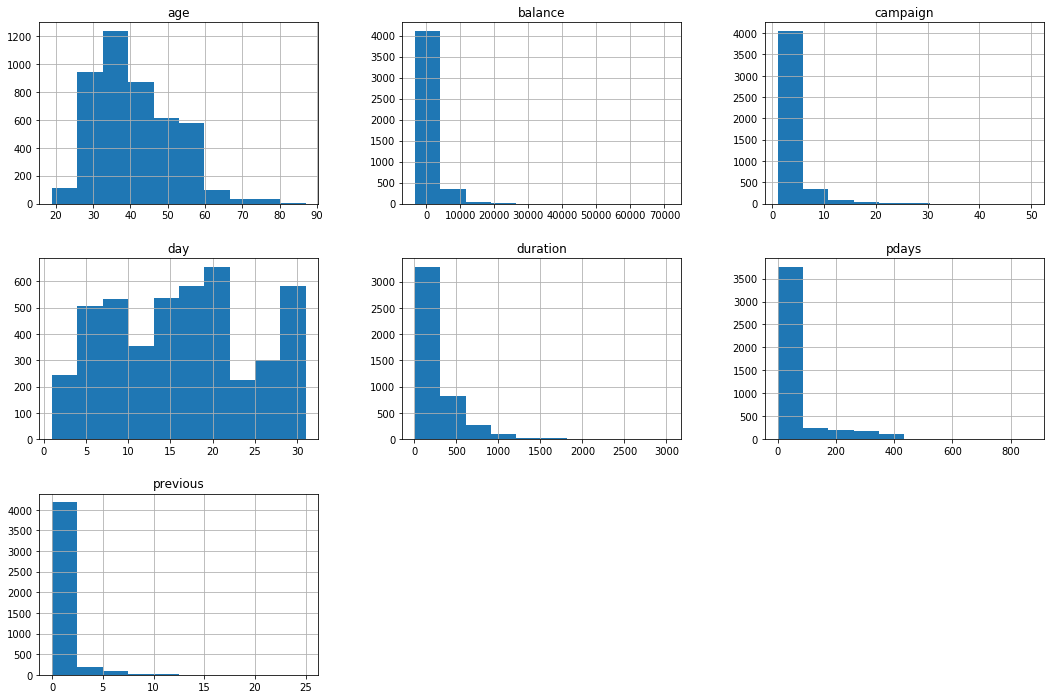

In [79]:
__ = Bankdata.hist(column=Bankdata.columns, figsize = (18,12))

#### Visualization of categorical columns of the dataset

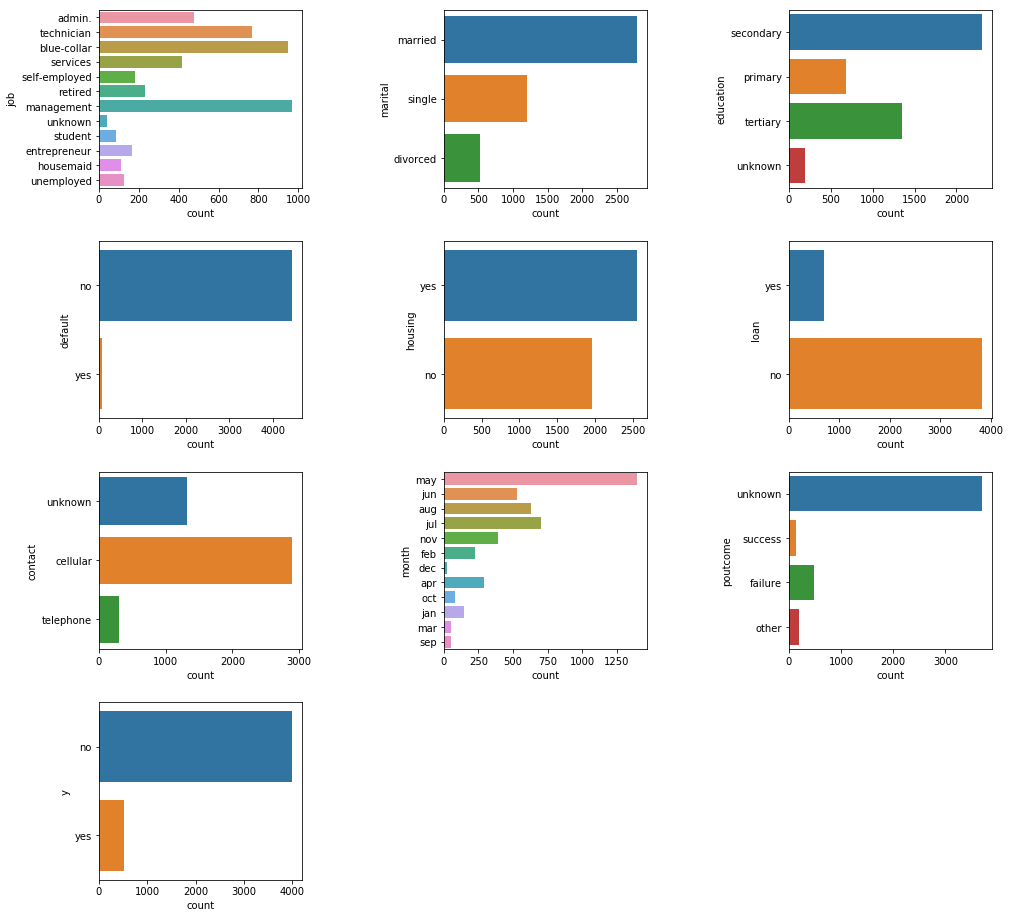

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y = Bankdata.describe(include=["object"]).columns[i], data=Bankdata, ax=ax)

#### Droping the unwanted columns from the dataset

In [80]:
Required_bankdata = Bankdata.drop(columns = ['day','month','housing','loan','duration'])
Required_bankdata = text_to_number(Required_bankdata,'y')
Required_bankdata.head()

,age,job,marital,education,default,balance,contact,campaign,pdays,previous,poutcome,y
831,47,blue-collar,married,secondary,no,1996,unknown,2,-1,0,unknown,1
3174,36,blue-collar,single,secondary,no,168,telephone,1,-1,0,unknown,0
4181,26,technician,single,secondary,no,1275,unknown,9,-1,0,unknown,0
3502,32,management,divorced,tertiary,no,883,cellular,1,185,5,other,1
4501,34,management,married,tertiary,no,297,cellular,4,-1,0,unknown,0


#### Check for Na and null values within the dataset and create dummies

In [81]:
Bankdata_dummies = check_na_null(Required_bankdata)
Bankdata_dummies.head()

,age,balance,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,education_unknown,default_no,default_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
831,47,1996,2,-1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3174,36,168,1,-1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4181,26,1275,9,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3502,32,883,1,185,5,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4501,34,297,4,-1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [82]:
Bankdata_dummies = normalise_data(Bankdata_dummies)
Bankdata_dummies.head()

,age,balance,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,education_unknown,default_no,default_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
831,0.016445,0.008918,0.007116,-0.000138,0.000000,0.043811,0.0,0.032513,0.0,0.0,...,0.0,0.014999,0.0,0.000000,0.000000,0.027482,0.0,0.000000,0.0,0.016429
3174,0.012596,0.000751,0.003558,-0.000138,0.000000,0.000000,0.0,0.032513,0.0,0.0,...,0.0,0.014999,0.0,0.000000,0.057639,0.000000,0.0,0.000000,0.0,0.016429
4181,0.009097,0.005697,0.032021,-0.000138,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.014999,0.0,0.000000,0.000000,0.027482,0.0,0.000000,0.0,0.016429
3502,0.011196,0.003945,0.003558,0.025542,0.041819,0.043811,0.0,0.000000,0.0,0.0,...,0.0,0.014999,0.0,0.018582,0.000000,0.000000,0.0,0.071247,0.0,0.000000
4501,0.011896,0.001327,0.014232,-0.000138,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.014999,0.0,0.018582,0.000000,0.000000,0.0,0.000000,0.0,0.016429


#### Create Train and test dataset

In [83]:
Y_data = np.array(Bankdata_dummies.y)
Bankdata_dummies = Bankdata_dummies.drop(columns = 'y')
X_data = np.array(Bankdata_dummies)
Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)

print("Xtrain: " ,X_train.shape)
print("Ytrain: " ,Y_train.shape)
print("Xtest: " ,X_test.shape)
print("Ytest: " ,Y_test.shape)

Xtrain:  (3617, 33)
Ytrain:  (3617,)
Xtest:  (904, 33)
Ytest:  (904,)


#### Calling Logistic regression using Gradient descent function

In [25]:
alpha = [1e-4,1e-5,1e-6,1e-4,1e-5,1e-6,1e-4,1e-5,1e-6]
reg = [9e-6,9e-6,9e-6,0.01,0.01,0.01,1e-4,1e-4,1e-4]

IndexError: list index out of range

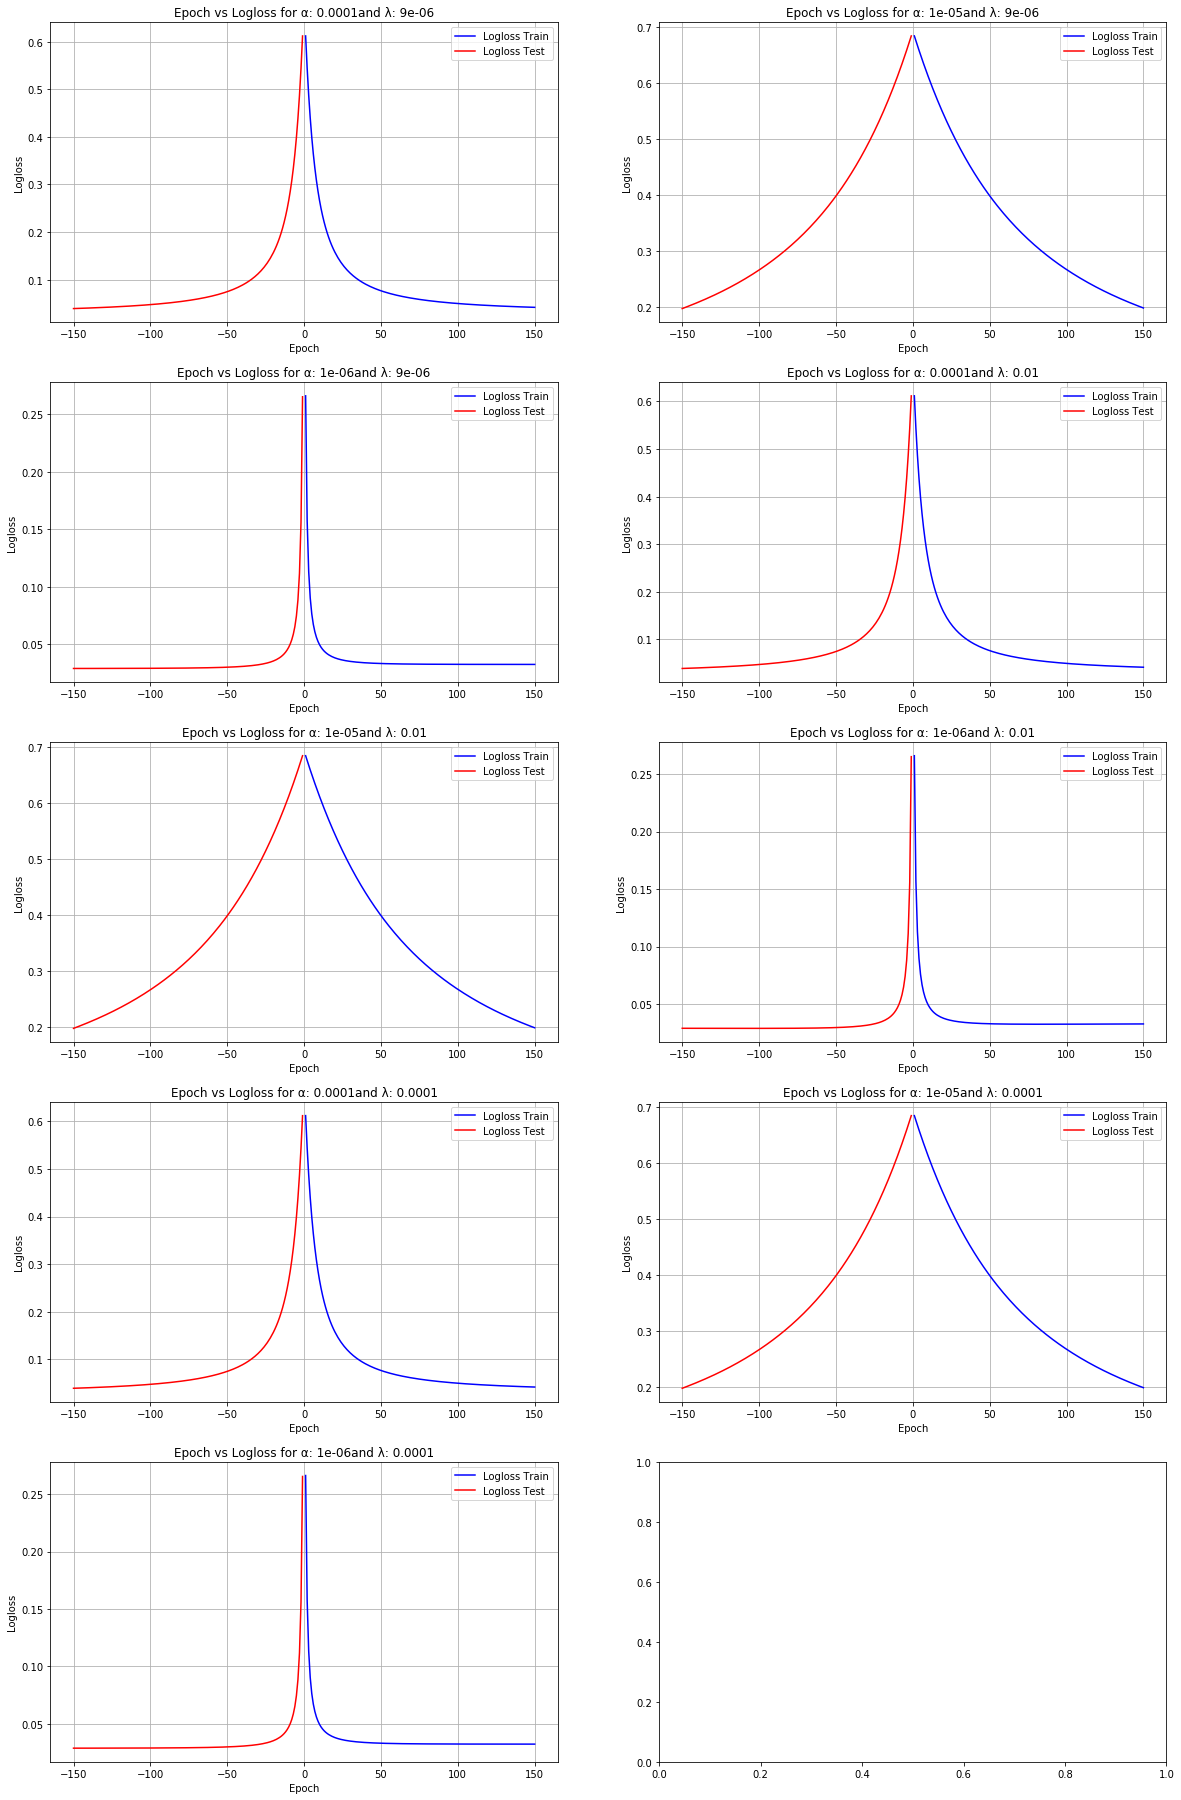

In [26]:
negrange = -np.arange(1,len(test_graph[0])+1)
posrange = np.arange(1,len(test_graph[0])+1)
fig, axs = plt.subplots(5, 2, figsize=(20, 32))
i = 0
for axis in range(0,5):
    axs[axis][0].set_title('Epoch vs Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(posrange,train_graph[i],'b',label = 'Logloss Train')
    axs[axis][0].plot(negrange,test_graph[i],'r',label='Logloss Test')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("Logloss")
    axs[axis][0].legend()
    i+=1
    axs[axis][1].set_title('Epoch vs Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(posrange,train_graph[i],'b',label = 'Logloss Train')
    axs[axis][1].plot(negrange,test_graph[i],'r',label='Logloss Test')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("Logloss")
    axs[axis][1].legend()
    i+=1

Best Model using Regularization:
	α: 1e-06
	λ: 0.0001
	Logloss: 0.03245587884785722


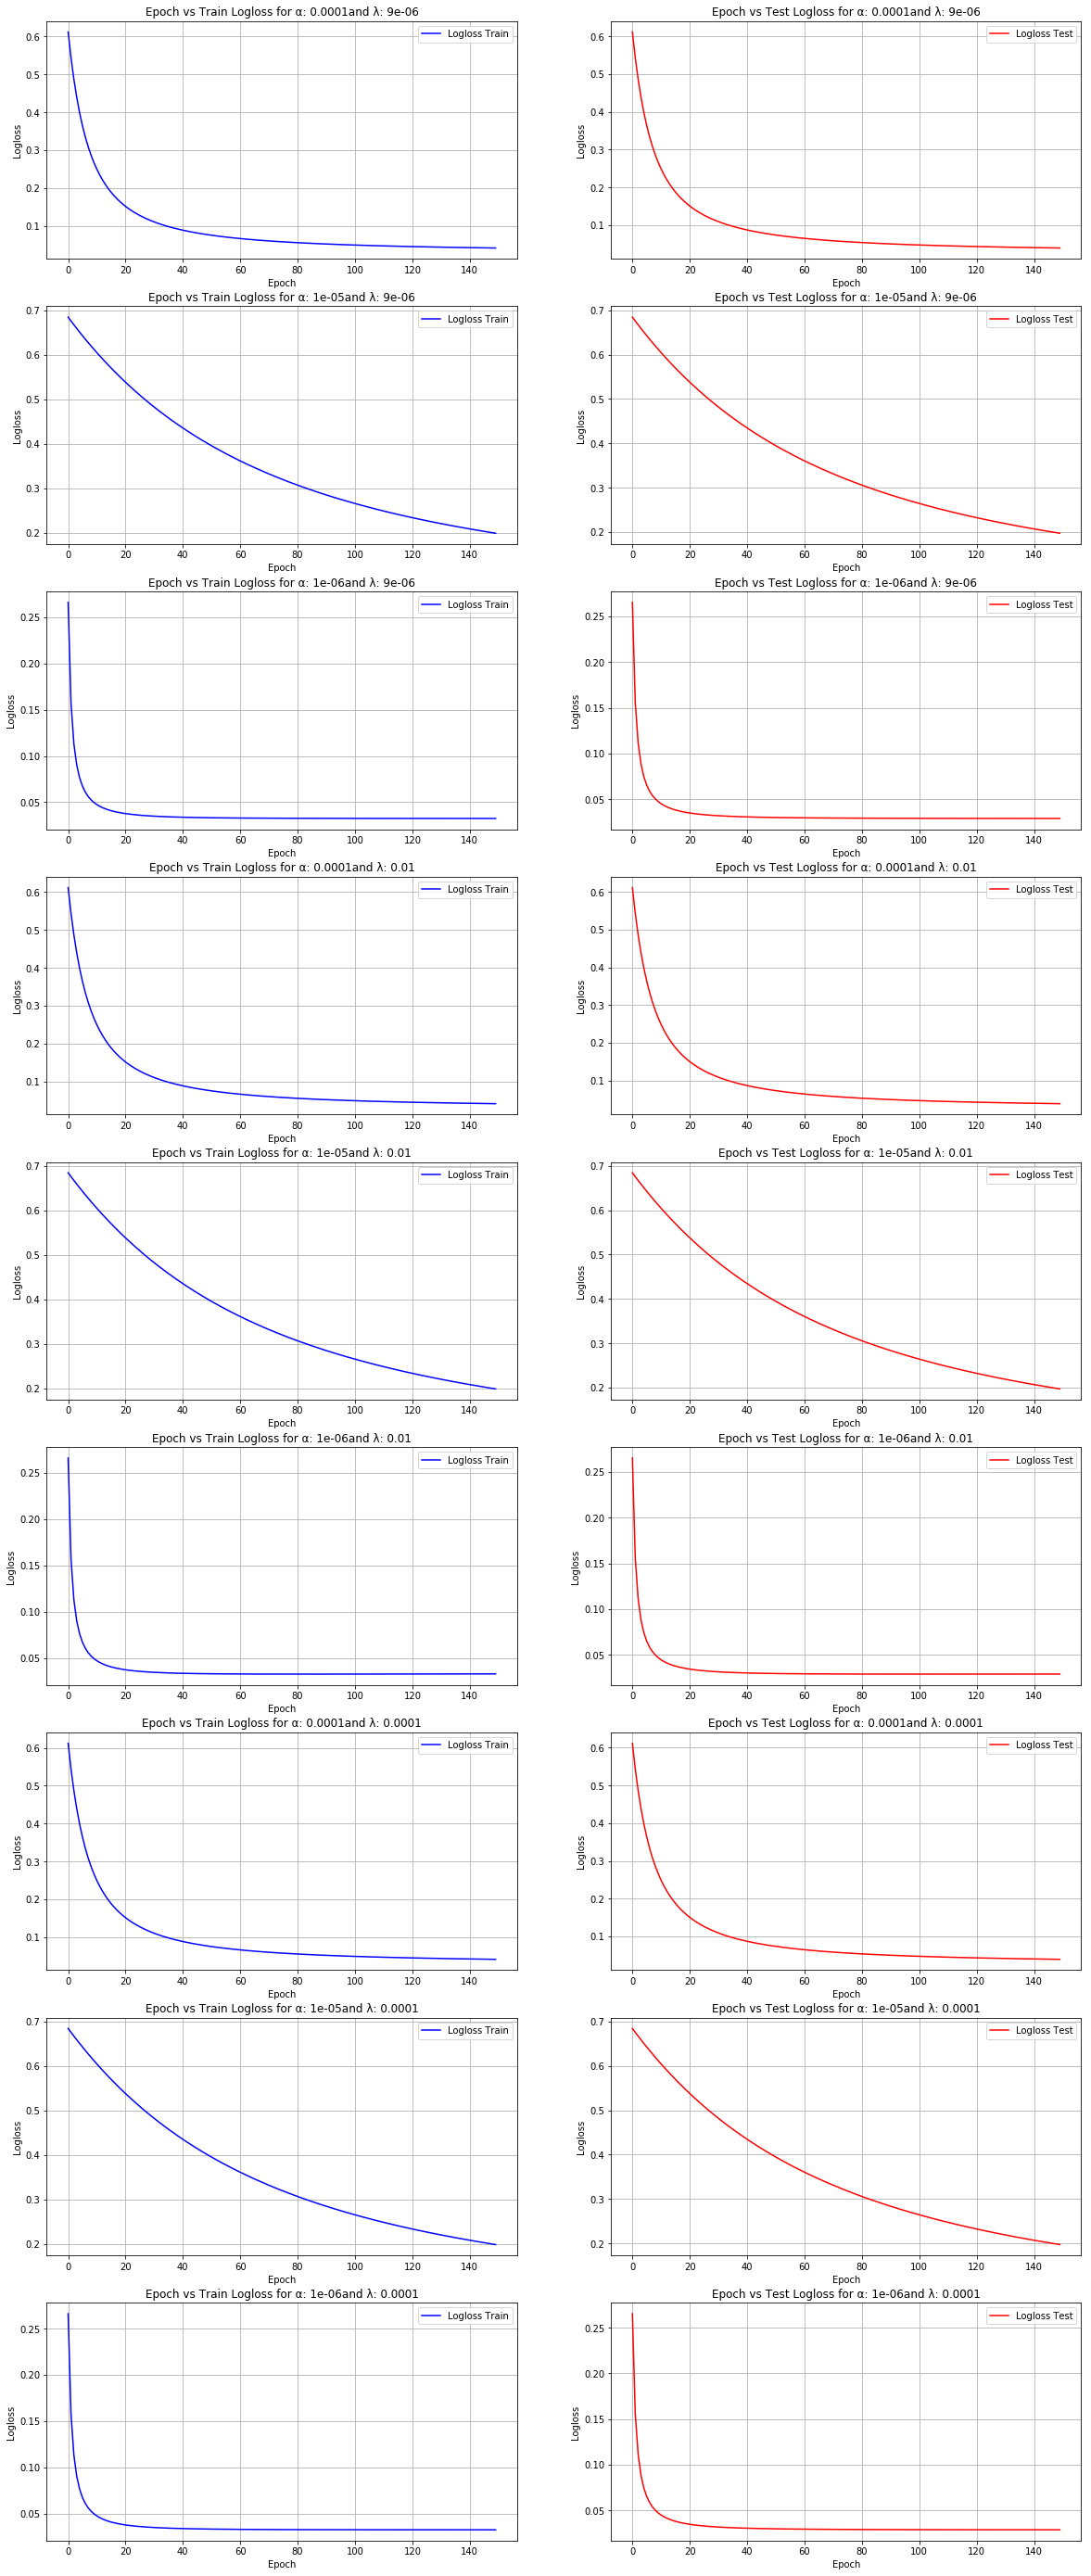

In [27]:
fig, axs = plt.subplots(9, 2, figsize=(20, 50))
i = 0
for axis in range(0,9):
    axs[axis][0].set_title('Epoch vs Train Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(train_graph[i],'b',label = 'Logloss Train')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("Logloss")
    axs[axis][0].legend()
    axs[axis][1].set_title('Epoch vs Test Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(test_graph[i],'r',label='Logloss Test')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("Logloss")
    axs[axis][1].legend()
    i+=1

minloss = train_graph[0][-1]
mincmb = 0
for i in range(0,len(train_graph)):
    if minloss > train_graph[i][-1]:
        minloss = train_graph[i][-1]
        mincmb = i
i=mincmb
print("Best Model using Regularization:\n\tα: "+str(alpha[i])+"\n\tλ: "+str(reg[i])+"\n\tLogloss: "+str(minloss))

## Hyper parameter tuning

In [84]:
def kfold(X_train,Y_train,alpha,reg,minibatchsize,fold):
    split = math.ceil(len(X_train)/fold)
    logloss_train = list()
    logloss_valid = list()
    for i in range (0,fold):
        start = i*split
        end = i*split+split
        
        if start ==0:
            fold_Xtest = X_train[start:end]
            fold_Xtrain = X_train[end:]
            fold_Ytest = Y_train[start:end]
            fold_Ytrain = Y_train[end:]
            fold_Xtrainold = fold_Xtrain
        else:
            fold_Xtest = X_train[start:end]
            fold_Xtrain1 = X_train[0:start]
            fold_Xtrain2 = X_train[end:-1]
            fold_Xtrain = np.concatenate((fold_Xtrain1,fold_Xtrain2))
            fold_Ytest = Y_train[start:end]
            fold_Ytrain1 = Y_train[0:start]
            fold_Ytrain2 = Y_train[end:-1]
            fold_Ytrain = np.concatenate((fold_Ytrain1,fold_Ytrain2))
        train_graph,valid_graph = ridgereg_gd(fold_Ytrain,fold_Ytest,fold_Xtrain,fold_Xtest,alpha,reg,minibatchsize,'Tune')
        logloss_train.append(train_graph)
        logloss_valid.append(valid_graph)
    return logloss_train,logloss_valid

In [85]:
def gridsearch(Y_train,X_train,alpha,reg,minibatchsize,fold):
    
    train_graph = list()
    valid_graph = list()
    logloss_train = list()
    logloss_valid = list()
    for i in range(0,len(reg)):
        for j in range(0,len(alpha)):
            train_graph,valid_graph = kfold(X_train,Y_train,alpha[j],reg[i],minibatchsize,fold)
            logloss_train.append(train_graph)
            logloss_valid.append(valid_graph)
    return logloss_train,logloss_valid

In [86]:
alpha = [1e-4,5.2e-5,3.7e-3,2e-7]
reg = [9e-16,0.01,1e-4,0.1,1e-9]
# alpha = [1e-3]
# reg = [9e-6,0.01]
minibatchsize = 50
fold = 5
train_graph = list()
valid_graph = list()
train_graph,valid_graph = gridsearch(Y_train,X_train,alpha,reg,minibatchsize,fold)

In [87]:
alpha = [1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7]
reg = [9e-16,9e-16,9e-16,9e-16,0.01,0.01,0.01,0.01,1e-4,1e-4,1e-4,1e-4,0.1,0.1,0.1,0.1,1e-9,1e-9,1e-9,1e-9]

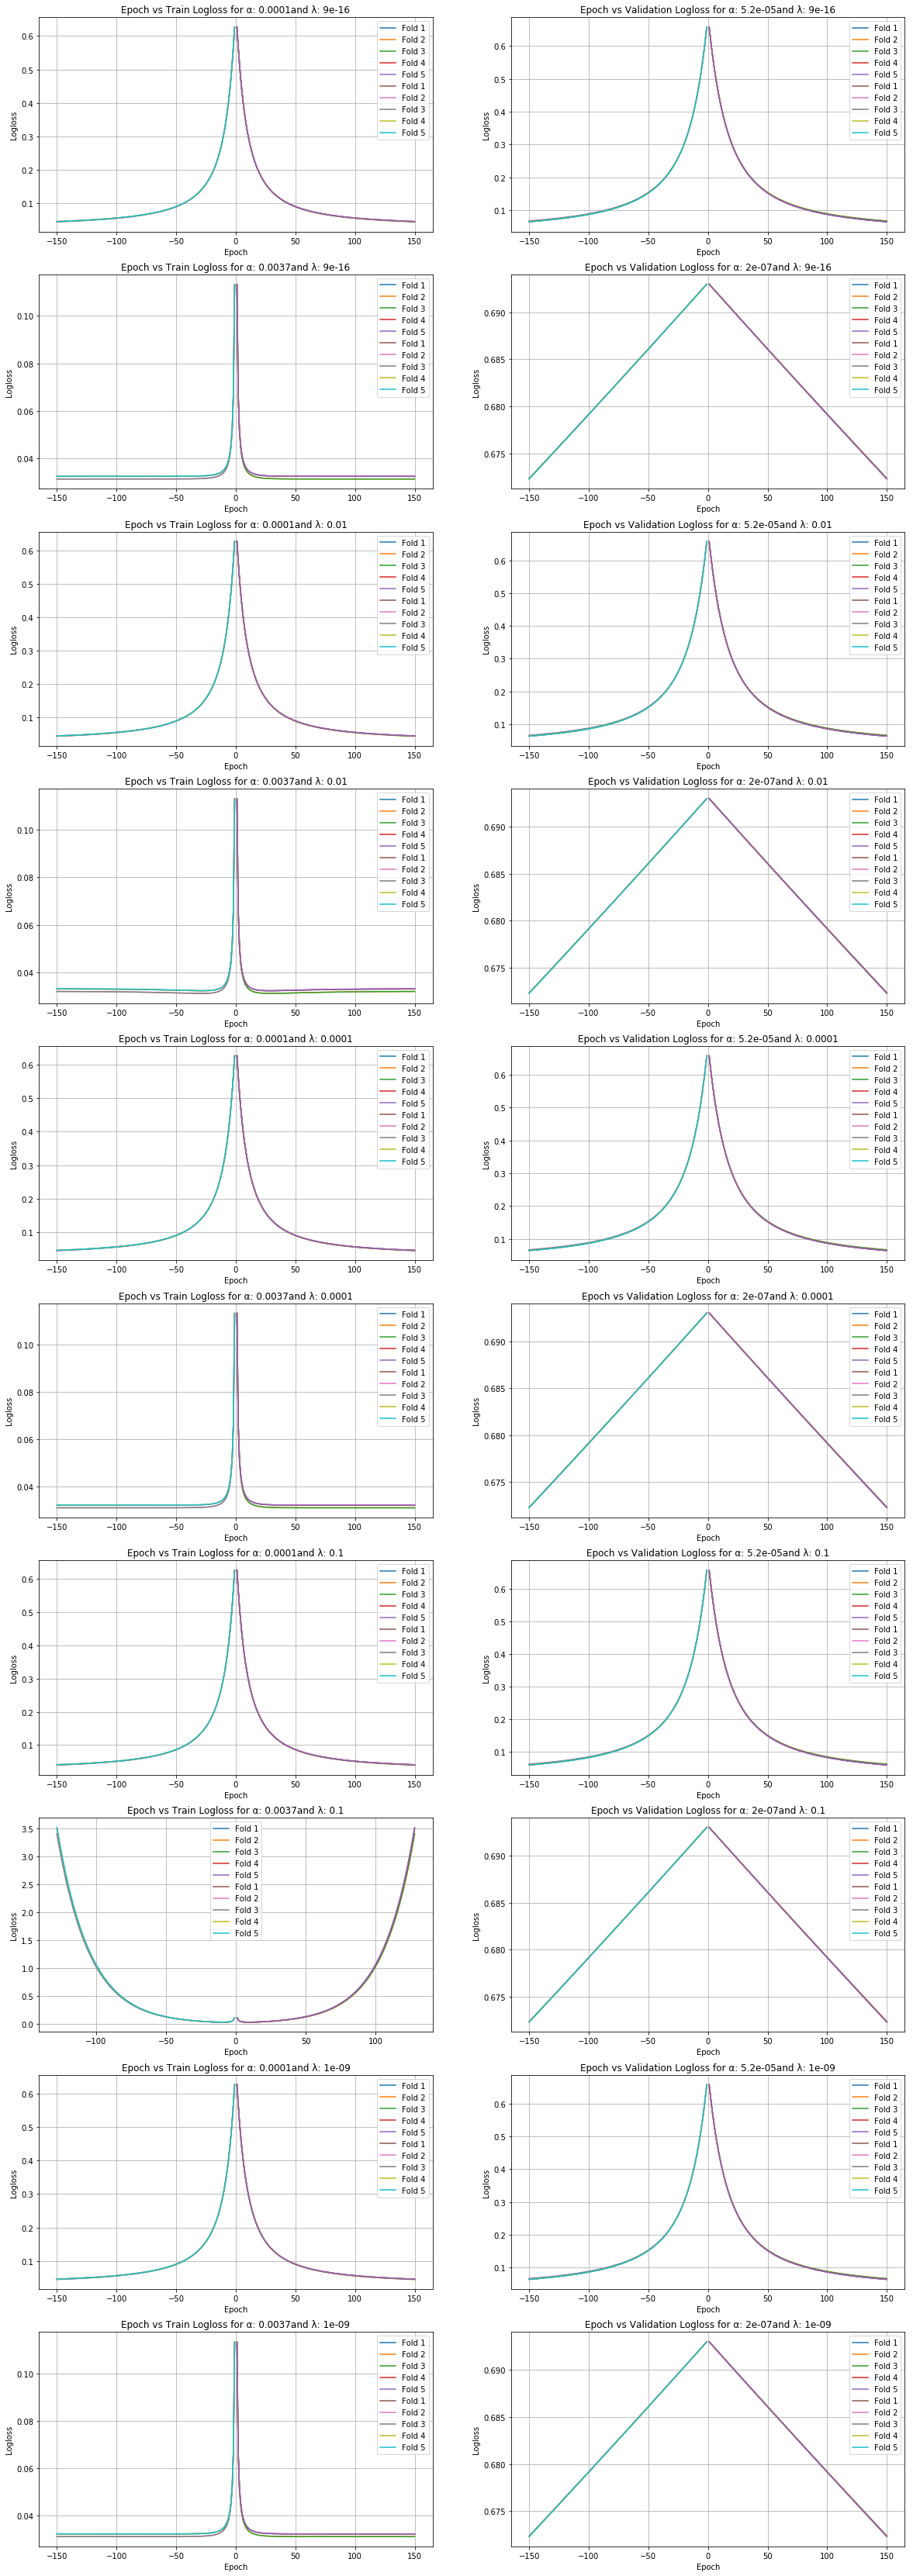

In [88]:
negrange = -np.arange(1,len(valid_graph[0][0])+1)
posrange = np.arange(1,len(valid_graph[0][0])+1)
fig, axs = plt.subplots(10, 2, figsize=(20, 60))
i = 0
for axis in range(0,10):
    axs[axis][0].set_title('Epoch vs Train Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(posrange,train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(posrange,train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(posrange,train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(posrange,train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(posrange,train_graph[i][4],label = 'Fold 5')
    axs[axis][0].plot(negrange,train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(negrange,train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(negrange,train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(negrange,train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(negrange,train_graph[i][4],label = 'Fold 5')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("Logloss")
    axs[axis][0].legend()
    i+=1
    axs[axis][1].set_title('Epoch vs Validation Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(posrange,valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(posrange,valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(posrange,valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(posrange,valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(posrange,valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].plot(negrange,valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(negrange,valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(negrange,valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(negrange,valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(negrange,valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("Logloss")
    axs[axis][1].legend()
    i+=1

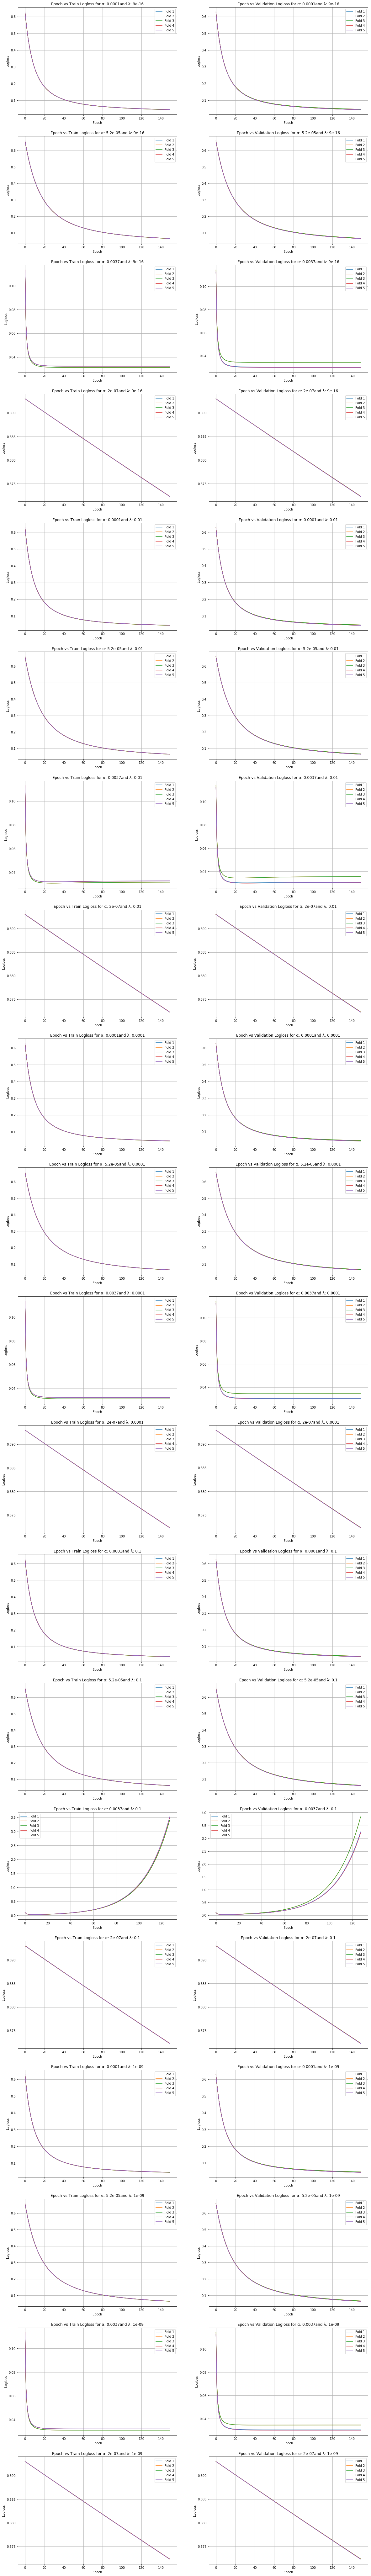

In [89]:
fig, axs = plt.subplots(20, 2, figsize=(20, 150))
i = 0
for axis in range(0,20):
    axs[axis][0].set_title('Epoch vs Train Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(train_graph[i][4],label = 'Fold 5')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("Logloss")
    axs[axis][0].legend()
    axs[axis][1].set_title('Epoch vs Validation Logloss for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("Logloss")
    axs[axis][1].legend()
    i+=1

In [34]:
logloss = list()
for i in range(0,len(train_graph)):
    average = 0
    for j in range(0,len(train_graph[i])):
        average += (train_graph[i][j][-1])
    average = average/5
    if math.isnan(average):
        average = 0
    else:
        logloss.append(average)

In [35]:
len(logloss)

19

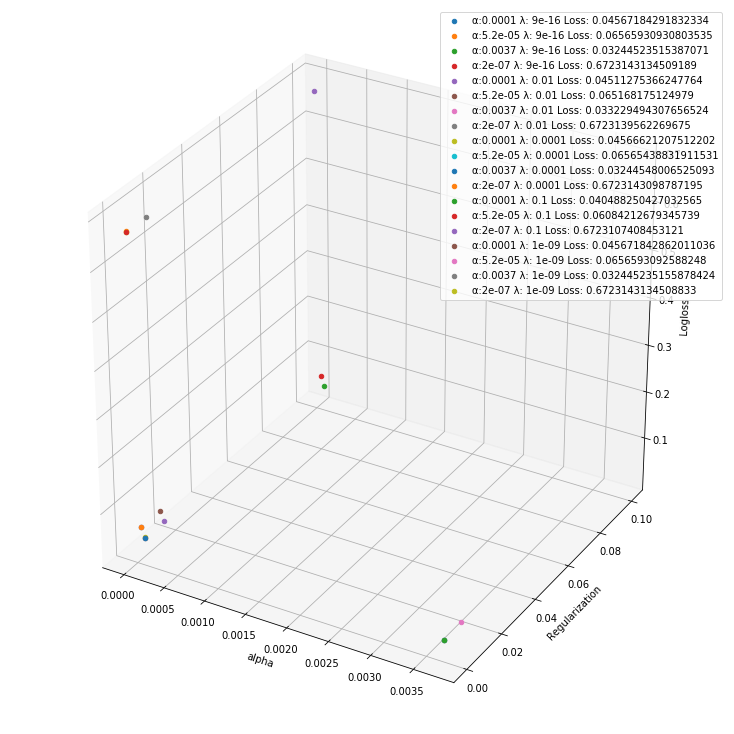

Best Model using Grid search with k-fold cross validation:
	α: 0.0037
	λ: 9e-16
	Logloss: 0.03244523515387071


In [36]:
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
alpha = [1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,3.7e-3,2e-7,1e-4,5.2e-5,2e-7,1e-4,5.2e-5,3.7e-3,2e-7]
reg = [9e-16,9e-16,9e-16,9e-16,0.01,0.01,0.01,0.01,1e-4,1e-4,1e-4,1e-4,0.1,0.1,0.1,1e-9,1e-9,1e-9,1e-9]
for i in range(0,19):
    ax.scatter(xs=alpha[i], ys=reg[i], zs=logloss[i], zdir='z', label="α:"+str(alpha[i])+" λ: "+str(reg[i])+" Loss: "+str(logloss[i]))
ax.set_xlabel("alpha")
ax.set_ylabel("Regularization")
ax.set_zlabel("Logloss")
ax.legend()
plt.show()

i = logloss.index(min(logloss))
print("Best Model using Grid search with k-fold cross validation:\n\tα: "+str(alpha[i])+"\n\tλ: "+str(reg[i])+"\n\tLogloss: "+str(logloss[i]))


In [92]:
alpha = [0.0037]
reg = [9e-16]

minibatchsize = 50
train_graph = list()
test_graph = list()
train_graph,test_graph = ridgereg_gd(Y_train,Y_test,X_train,X_test,alpha,reg,minibatchsize,None)
train_graph = denormalise_data(Bankdata_dummies,train_graph)
test_graph = denormalise_data(Bankdata_dummies,test_graph)


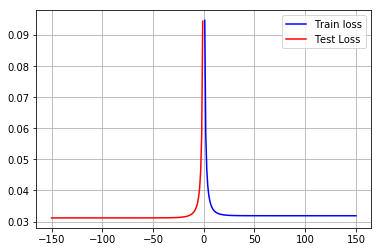

In [93]:
negrange = -np.arange(1,len(test_graph[0])+1)
posrange = np.arange(1,len(test_graph[0])+1)
plt.plot(posrange,train_graph[0],'b',label="Train loss")
plt.plot(negrange,test_graph[0],'r',label='Test Loss')
plt.legend()
plt.grid()